<div align="center">
  <span style="font-size:30px;"><b>Setup and Imports</b></span>
</div>

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay)
from pympler import asizeof

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV


import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import pickle
import time

import warnings
warnings.filterwarnings('ignore')

<p style="text-align:center;">
  <span style="font-size:30px;"><b>Load Data</b></span>
</p>


In [35]:
train_identity = pd.read_csv("/Users/roshanshetty/Downloads/PROJECT_PHASE_1/dataset/train_identity.csv")
train_transaction = pd.read_csv("/Users/roshanshetty/Downloads/PROJECT_PHASE_1/dataset/train_transaction.csv")
df = pd.merge(train_identity,train_transaction, on='TransactionID', how='left')

<p style="text-align:center;">
  <span style="font-size:30px;"><b>1. EDA and Preprocessing</b></span>
</p>

<b>Objective:</b> Set the foundation for the project by exploring data in-depth and 
handling preprocessing challenges.


<ul style="text-align:left; font-size:20px;">
  <li><b>Dataset Introduction</b></li>
</ul>

In [36]:
print(df.head())
print(df.info())

   TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  ...  V330  V331 V332  V333  V334 V335 V336  V337  V338  V339  
0    NaN  ...   0.0   0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  
1    NaN  ...   0.0   0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  
2    0.0  ...   NaN   NaN  NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN  
3    NaN  ...   NaN   NaN  NaN   NaN   NaN  NaN  NaN   NaN   NaN   NaN  
4    0.0  ...   0.0   0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  

[5 rows x 434 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144233 entrie

This dataset contains **144,233 transactions** with **434 features** each, including numeric IDs, V features, and some categorical columns.  
Most columns are floats, with some objects (likely representing categorical data), and there is significant missing data in several fields.


The Transaction dataset records various types of financial transactions, including money transfers, ticket bookings, and purchases. It contains the following attributes:

1. **TransactionDT**: A time-delta value representing the time elapsed since a reference point, but not an actual timestamp.

2. **TransactionAMT**: The transaction amount in USD.

3. **ProductCD**: The product code associated with the transaction.

4. **card1 – card6**: Details related to the payment card used for the transaction.

5. **addr1 and addr2**: The purchaser's address information.

6. **dist1 and dist2**: The geographical distance between two transaction locations.

7. **P_emaildomain and R_emaildomain**: The email domains of the purchaser and recipient.

8. **C1 – C14**: Counts representing how many addresses are linked to the card.

9. **D1 – D15**: Time-based deltas indicating the number of days between consecutive transactions.

10. **M1 – M9**: Matching indicators, such as whether the cardholder's name matches the provided address.

11. **V1 – V339**: Entity relationship attributes provided by Vesta, capturing additional transaction details.



**VXXX**- IS THE INFORMATION PROVIDED BY THE **VESTA** SPECIFIYING THE ENTITY RELATION




<p style="text-align:left;">
  <span style="font-size:20px;"><b>Vesta-Engineered Features</b></span>
</p>
  

  Vesta is a fraud detection and payment processing company specializing in machine learning models for transaction risk assessment. The Vesta-engineered features (V1 to V339) are derived from raw transaction data to enhance fraud detection.


**Types of Features in V1 to V339**

  These features are anonymized but typically include:

1. **Ranking-Based Features**

  How a transaction compares to others (e.g., is this amount unusually high for this user?).

  Example: Rank of transaction amount within a certain timeframe.


2. **Counting-Based Features**

  How often a particular entity (e.g., card, email, IP address) appears.

  Example: Number of transactions from the same card in the past week.

3. **Entity Relationship Features**

  Connections between users, devices, locations, and payment methods.

  Example: Is this IP address linked to multiple different cards?

4. **Time-Series Features**

  Trends in transaction behavior over time.

  Example: Time gap between consecutive transactions for a user.


**Why Are These Features Important?**
  
  * Detect unusual patterns that indicate fraud.

* Enhance model accuracy by encoding risk factors from raw transaction data.

* Help prevent fraud in real-time by identifying suspicious behaviors.

In [37]:
df.describe()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,1.442330e+05,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,...,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000,82041.000000
mean,3.236329e+06,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,...,0.777733,723.339755,1379.108414,1017.190218,9.837929,59.213495,28.592672,55.461163,151.546395,100.950114
std,1.788496e+05,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,...,4.735065,6222.466950,11181.344838,7964.623789,244.320100,388.035252,275.048519,669.707372,1096.739466,816.354359
min,2.987004e+06,-100.000000,1.000000,-13.000000,-28.000000,-72.000000,-100.000000,-46.000000,-100.000000,-36.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.077142e+06,-10.000000,67992.000000,0.000000,0.000000,0.000000,-6.000000,5.000000,-48.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.198818e+06,-5.000000,125800.500000,0.000000,0.000000,0.000000,0.000000,14.000000,-34.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.392923e+06,-5.000000,228749.000000,0.000000,0.000000,1.000000,0.000000,22.000000,-23.000000,0.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.577534e+06,0.000000,999595.000000,10.000000,0.000000,52.000000,0.000000,61.000000,0.000000,25.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.000000,55125.000000,104060.000000,104060.000000,104060.000000



<p style="text-align:left;">
  <span style="font-size:20px;"><b>Insights from the Dataset</b></span>
</p>

1. **Potentially Imbalanced Data**

  * Some columns have very high skewness, meaning outliers or anomalies exist.

2. **High Amount of Missing Data**
  
  * Features like id_08, id_09 have significantly fewer records, requiring imputation or handling techniques.

3. **Zero-Inflated Features**
  
 * Many features contain mostly zeros, indicating categorical nature or sparsity.

4. **Large Numeric Variance**

  * Some features (V330-V339) have large ranges, suggesting possible monetary transactions or scoring mechanisms.



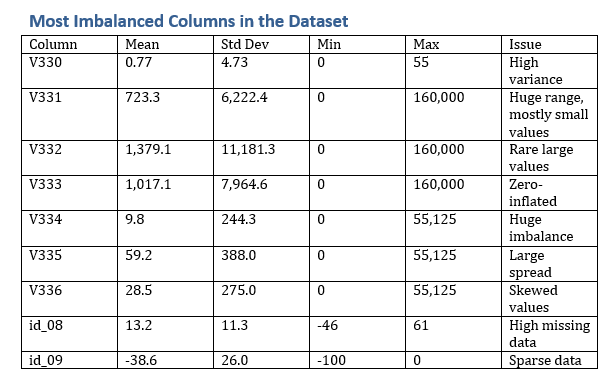




<ul style="text-align:left; font-size:20px;">
  <li><b>Exploratory Data Analysis</b></li>
</ul>

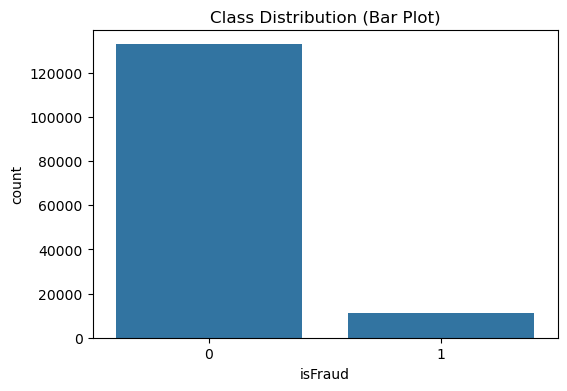

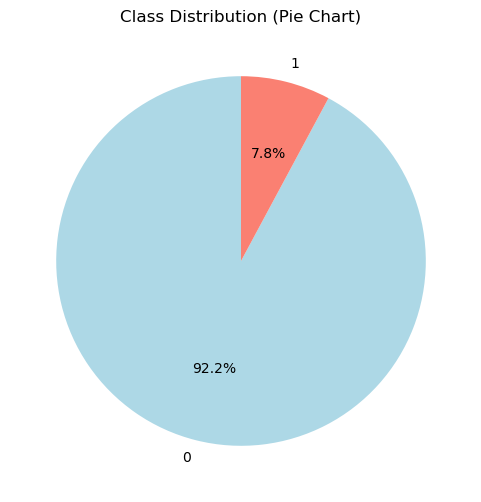

In [38]:
# Visualize class imbalance
plt.figure(figsize=(6,4))
sns.countplot(x='isFraud', data=df)
plt.title('Class Distribution (Bar Plot)')
plt.show()

plt.figure(figsize=(6,6))
df['isFraud'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
plt.title('Class Distribution (Pie Chart)')
plt.ylabel('')
plt.show()


**The dataset is highly imbalanced, with 92.2% non-fraudulent and 7.8% fraudulent transactions.**

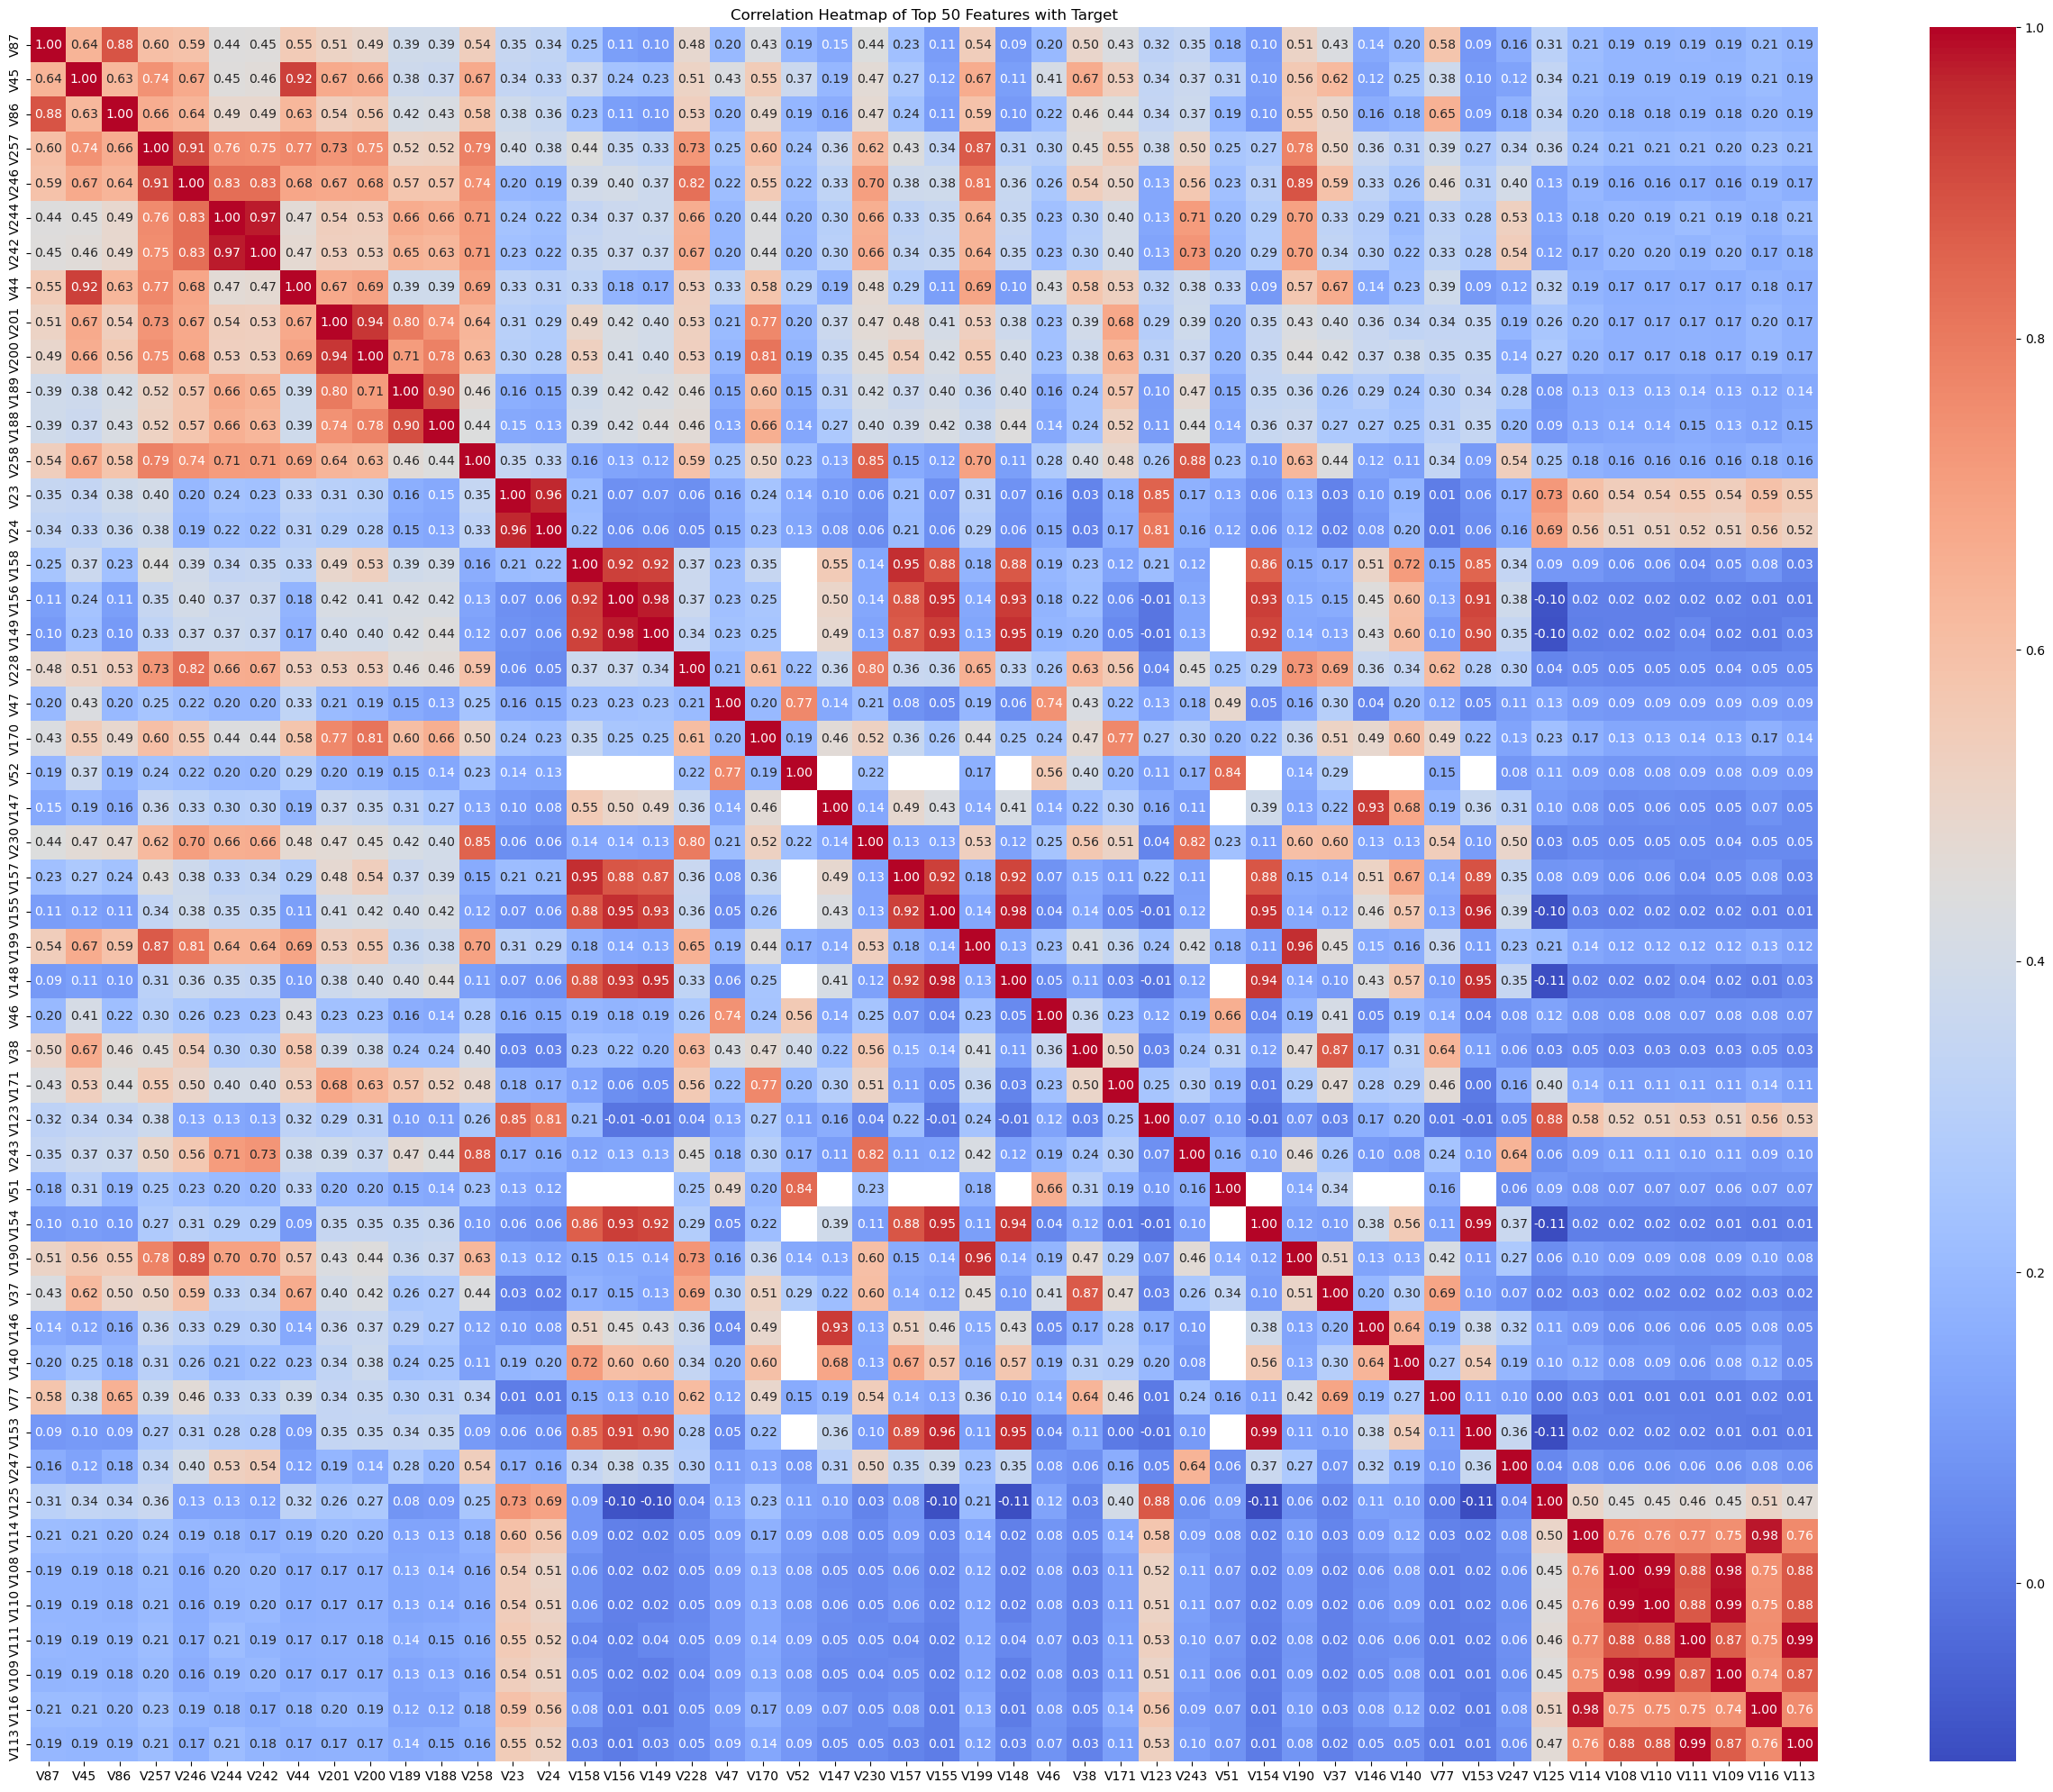

In [40]:
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Get absolute correlation with target
target_corr = corr_matrix["isFraud"].abs().sort_values(ascending=False)

# Select top N features (excluding "isFraud" itself)
top_features = target_corr[1:51].index

# Create smaller correlation matrix
small_corr = numeric_df[top_features].corr()

# Plot focused heatmap
plt.figure(figsize=(32, 25))
sns.heatmap(small_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap of Top 50 Features with Target")
plt.show()

**-The heatmap shows strong correlations among some features, indicating possible multicollinearity.**

**-Several features have moderate to high correlation with the target (isFraud), making them important for modeling.**

**-Careful feature selection or dimensionality reduction may be needed to avoid redundancy and improve model performance.**

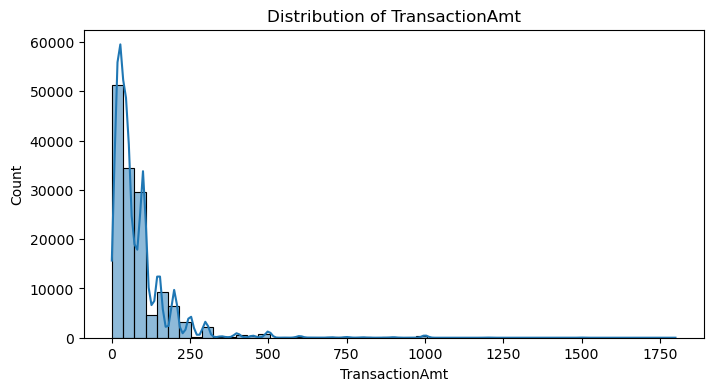

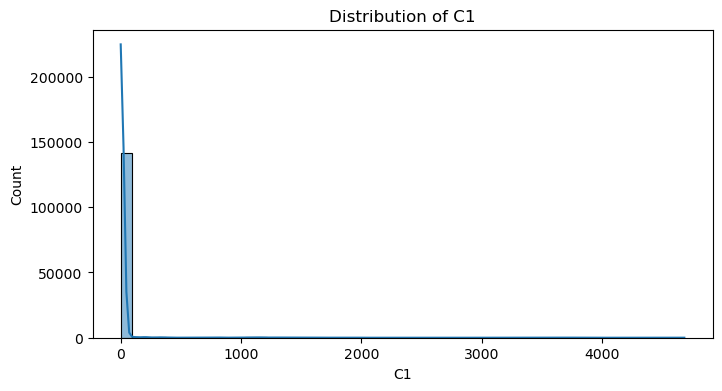

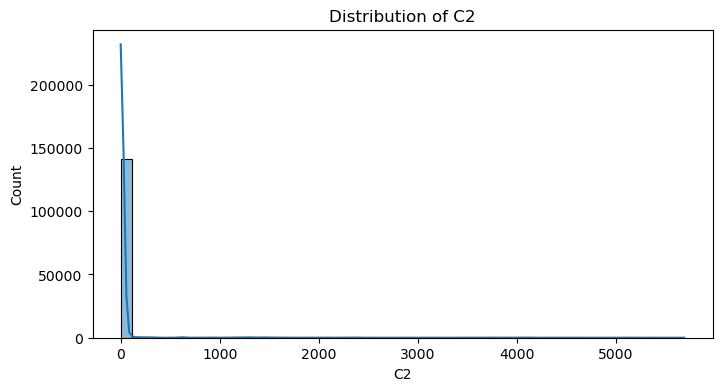

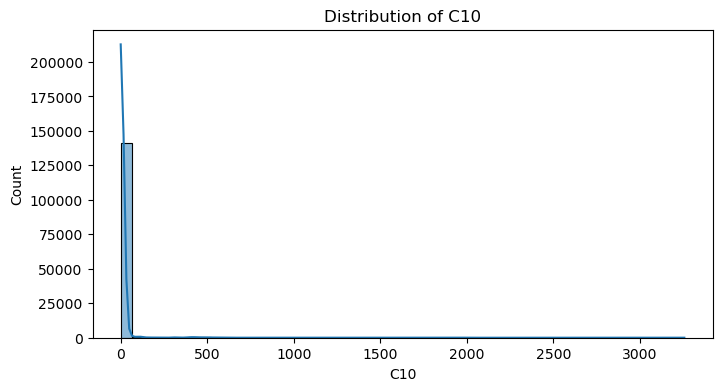

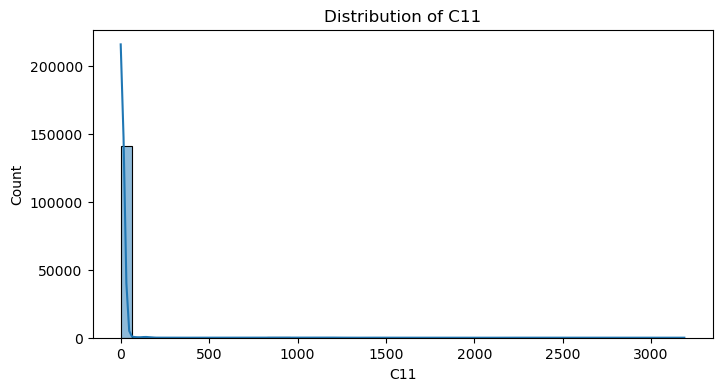

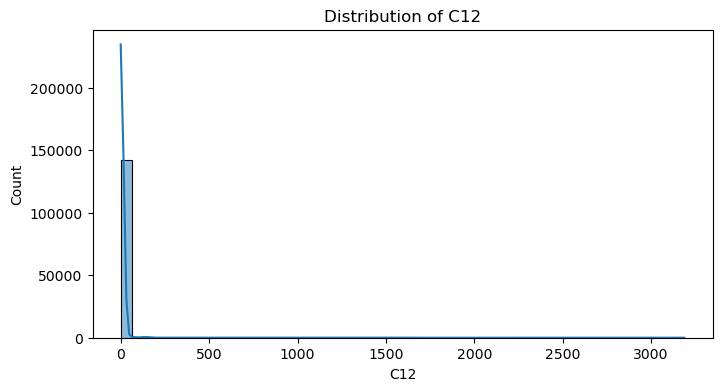

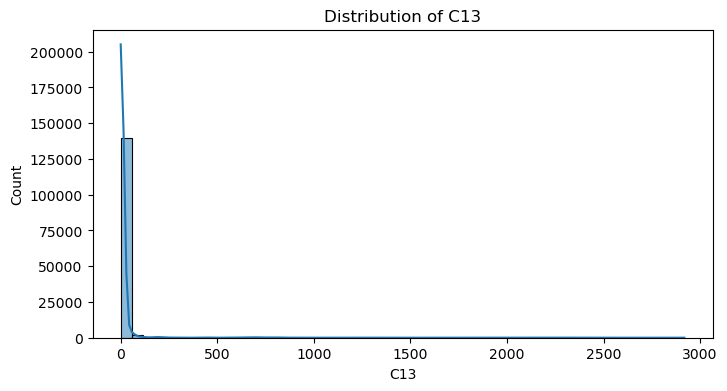

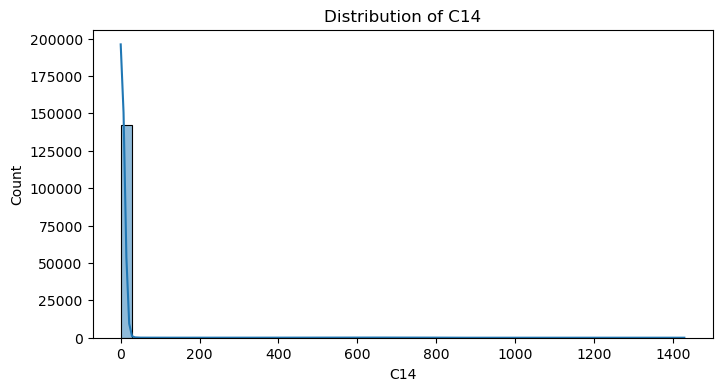

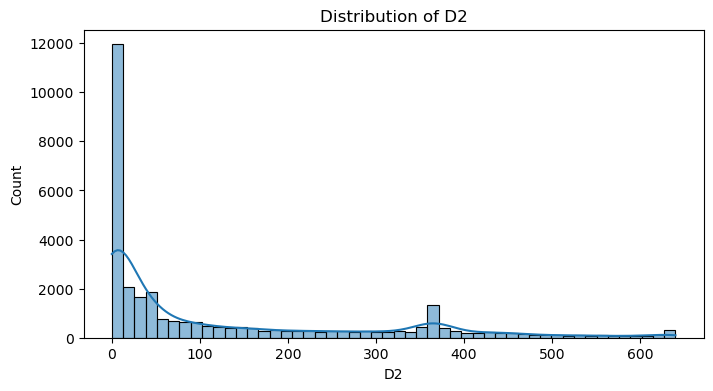

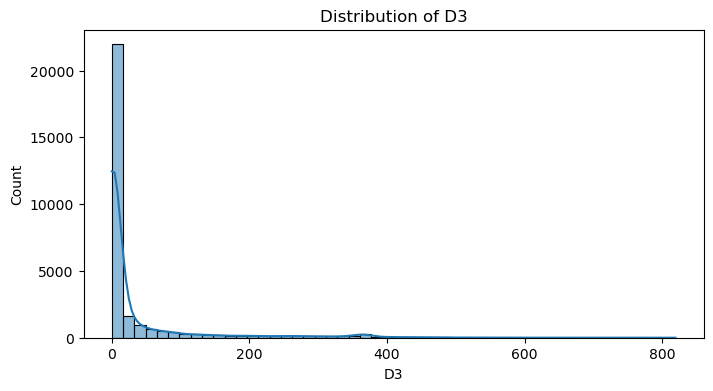

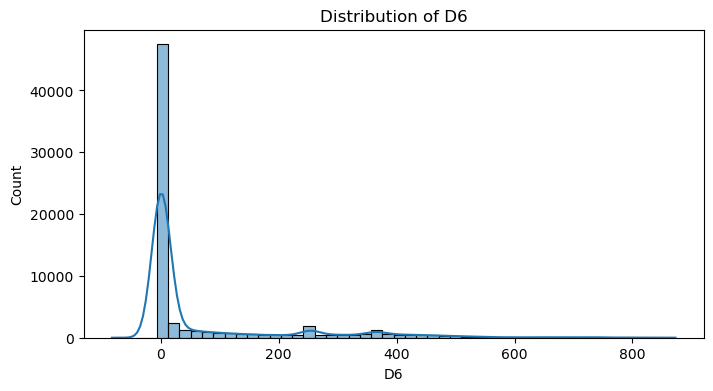

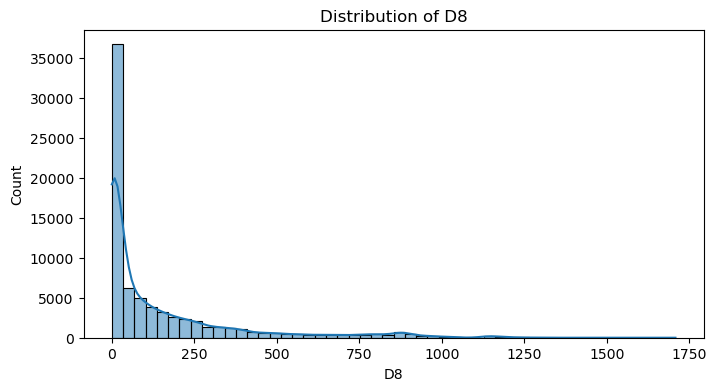

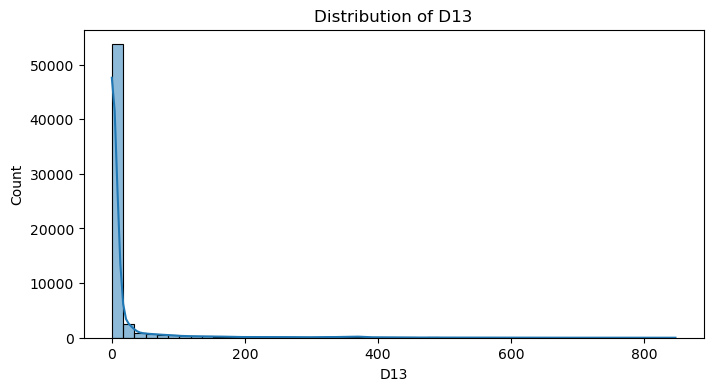

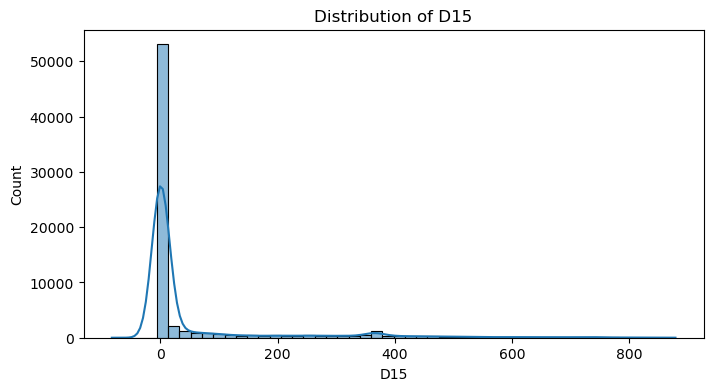

In [41]:
# Distribution of continuous features
continuous_features = ['TransactionAmt', 'C1', 'C2', 'C10', 'C11', 'C12', 'C13', 'C14', 
                       'D2', 'D3', 'D6', 'D8', 'D13', 'D15']

for col in continuous_features:
    if col in df.columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[col], bins=50, kde=True)
        plt.title(f'Distribution of {col}')
        plt.show()

- **Most transactions are small**: TransactionAmt peaks below 250, with few above 1000.  
- **C1-C14 are sparse**: High counts near zero, sharp drop-off—likely categorical or encoded data.  
- **D-features vary**: Some (D2, D3) peak low; others (D8) spread wider—possibly time-related.  
- **Outliers present**: Long tails in TransactionAmt and D8 suggest rare high values needing handling.



<ul style="text-align:left; font-size:20px;">
  <li><b>Data Preprocessing</b></li>
</ul>

In [42]:
# Replace "NotFound" with NaN
df.replace('NotFound', np.nan, inplace=True)

# Fill numeric columns with median
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

# Fill categorical columns with mode
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    mode_val = df[col].mode()
    if not mode_val.empty:
        df[col].fillna(mode_val[0], inplace=True)
    else:
        # If no mode found, you can choose to fill with a placeholder or 'Unknown'
        df[col].fillna('Unknown', inplace=True)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Feature scaling
scaler = StandardScaler()
scaled_numeric = scaler.fit_transform(df[numeric_cols])
df_scaled = pd.DataFrame(scaled_numeric, columns=numeric_cols)


Number of outliers detected using Z-score: 89941
Number of outliers detected using IQR: 141269


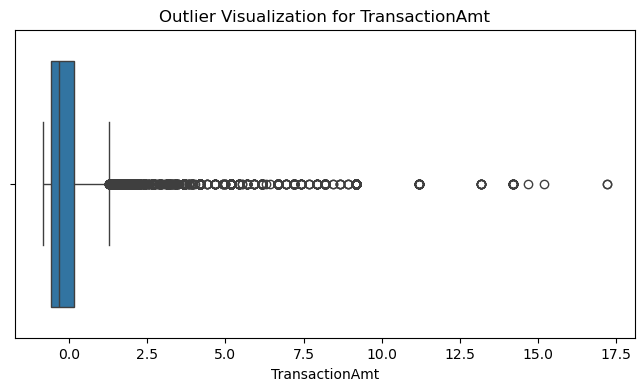

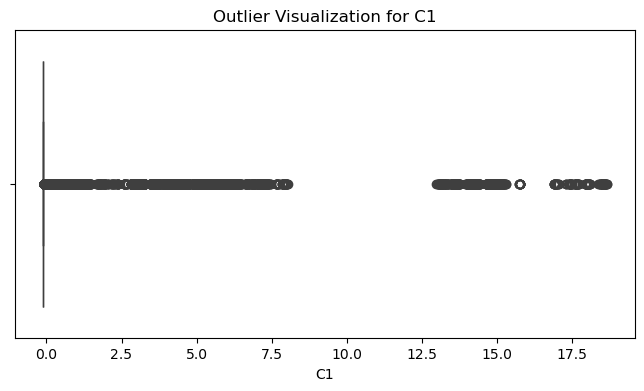

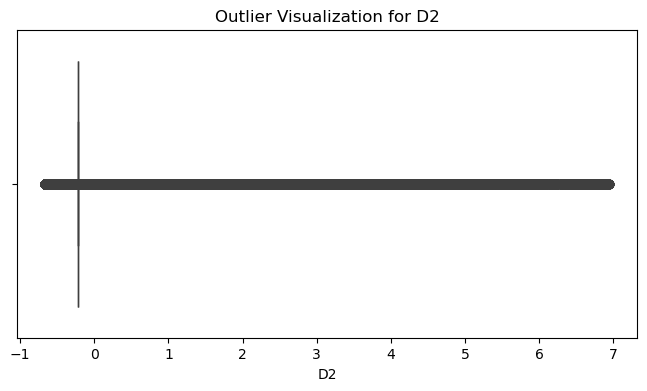


Data preprocessing complete!
Dataset shape after preprocessing: (144233, 434)
Outlier flags added to scaled DataFrame.


In [43]:
from scipy import stats
# Outlier detection using Z-score
z_scores = np.abs(stats.zscore(df_scaled))
outliers_z = (z_scores > 3).any(axis=1)
print(f"Number of outliers detected using Z-score: {outliers_z.sum()}")

# Outlier detection using IQR
Q1 = df_scaled.quantile(0.25)
Q3 = df_scaled.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((df_scaled < (Q1 - 1.5 * IQR)) | (df_scaled > (Q3 + 1.5 * IQR))).any(axis=1)
print(f"Number of outliers detected using IQR: {outliers_iqr.sum()}")

# Visualize example feature outliers
for col in ['TransactionAmt', 'C1', 'D2']:
    if col in df_scaled.columns:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=df_scaled[col])
        plt.title(f'Outlier Visualization for {col}')
        plt.show()

# Flag outliers
df_scaled['is_outlier_z'] = outliers_z.astype(int)
df_scaled['is_outlier_iqr'] = outliers_iqr.astype(int)

# Final Cleaned Data and Report


print("\nData preprocessing complete!")
print("Dataset shape after preprocessing:", df.shape)
print("Outlier flags added to scaled DataFrame.")


In [13]:
df.to_csv("cleaned_fraud_dataset.csv", index=False)

<p style="text-align:center;">
  <span style="font-size:30px;"><b>2. Feature Engineering and Imbalanced Data Handling</b></span>
</p>

<b>Objective:</b> : Engineer features and tackle imbalanced datasets



<ul style="text-align:left; font-size:20px;">
  <li><b>Feature Engineering</b></li>
</ul>

In [74]:
#Creating interaction features

# Ratio of transaction amount to global mean
df['Amt_to_mean_ratio'] = df['TransactionAmt'] / (df['TransactionAmt'].mean() + 1)

# Ratio to user historical average (using card1 as proxy)
if 'card1' in df.columns:
    user_mean = df.groupby('card1')['TransactionAmt'].transform('mean')
    df['Amt_to_user_mean_ratio'] = df['TransactionAmt'] / (user_mean + 1)

In [75]:
df['Amt_to_mean_ratio']

0         0.591334
1         0.177400
2         0.897492
3         0.195081
4         0.354801
            ...   
144228    0.578053
144229    2.956672
144230    0.873259
144231    4.730675
144232    0.798361
Name: Amt_to_mean_ratio, Length: 144233, dtype: float64

**Feature Selection**

**INFORMATION GAIN**

In [53]:
df = pd.read_csv("/Users/roshanshetty/Downloads/PROJECT_PHASE_1/Notebook/cleaned_fraud_dataset.csv")

def select_and_preprocess_features(df, target='isFraud', missing_threshold=0.75, verbose=True):
    """
    Selects numerical features with acceptable missing value rates,
    fills missing values with mean, and separates features and target.
    """
    # Geting numerical columns only (excluding the target)
    numerical_cols = [col for col in df.select_dtypes(include=np.number).columns if col != target]

    # Filtering the columns based on missing value threshold
    valid_cols = [col for col in numerical_cols if df[col].isnull().mean() < missing_threshold]

    if verbose:
        print(f"Kept {len(valid_cols)} numerical columns, dropped {len(numerical_cols) - len(valid_cols)}")

    # Creating a copy with selected features and target
    df_sub = df[valid_cols + [target]].copy()

    # Filling the missing values with mean for each numerical feature
    for col in valid_cols:
        df_sub[col] = df_sub[col].fillna(df_sub[col].mean())

    # Separate features and target
    X = df_sub[valid_cols]
    y = df_sub[target]

    return X, y


# Select and preprocess features
X_cleaned, y = select_and_preprocess_features(df, target='isFraud', verbose=True)

# Computing mutual information (information gain)
info_gain = mutual_info_classif(X_cleaned, y, random_state=42)

# Creating a DataFrame to store features and their information gain scores
info_gain_df = pd.DataFrame({
    'Feature': X_cleaned.columns,
    'Information_Gain': info_gain
}).sort_values(by='Information_Gain', ascending=False)

# Select top 100 features
top_n = 100
top_features_df = info_gain_df.head(top_n).reset_index(drop=True)

print(f"\n Top {top_n} Features by Information Gain:")
print(top_features_df)

Kept 420 numerical columns, dropped 13

 Top 100 Features by Information Gain:
          Feature  Information_Gain
0            V246          0.078933
1              C1          0.076030
2   TransactionID          0.074705
3   TransactionDT          0.074012
4            V258          0.072907
..            ...               ...
95          id_35          0.034179
96           V117          0.034077
97           V213          0.034028
98           V260          0.033629
99            V79          0.033457

[100 rows x 2 columns]


In [54]:
# Save top 100 features to CSV
top_features.to_csv('information_gain.csv', index=False)
print("Saved top 100 features to 'information_gain.csv'")

Saved top 100 features to 'information_gain.csv'


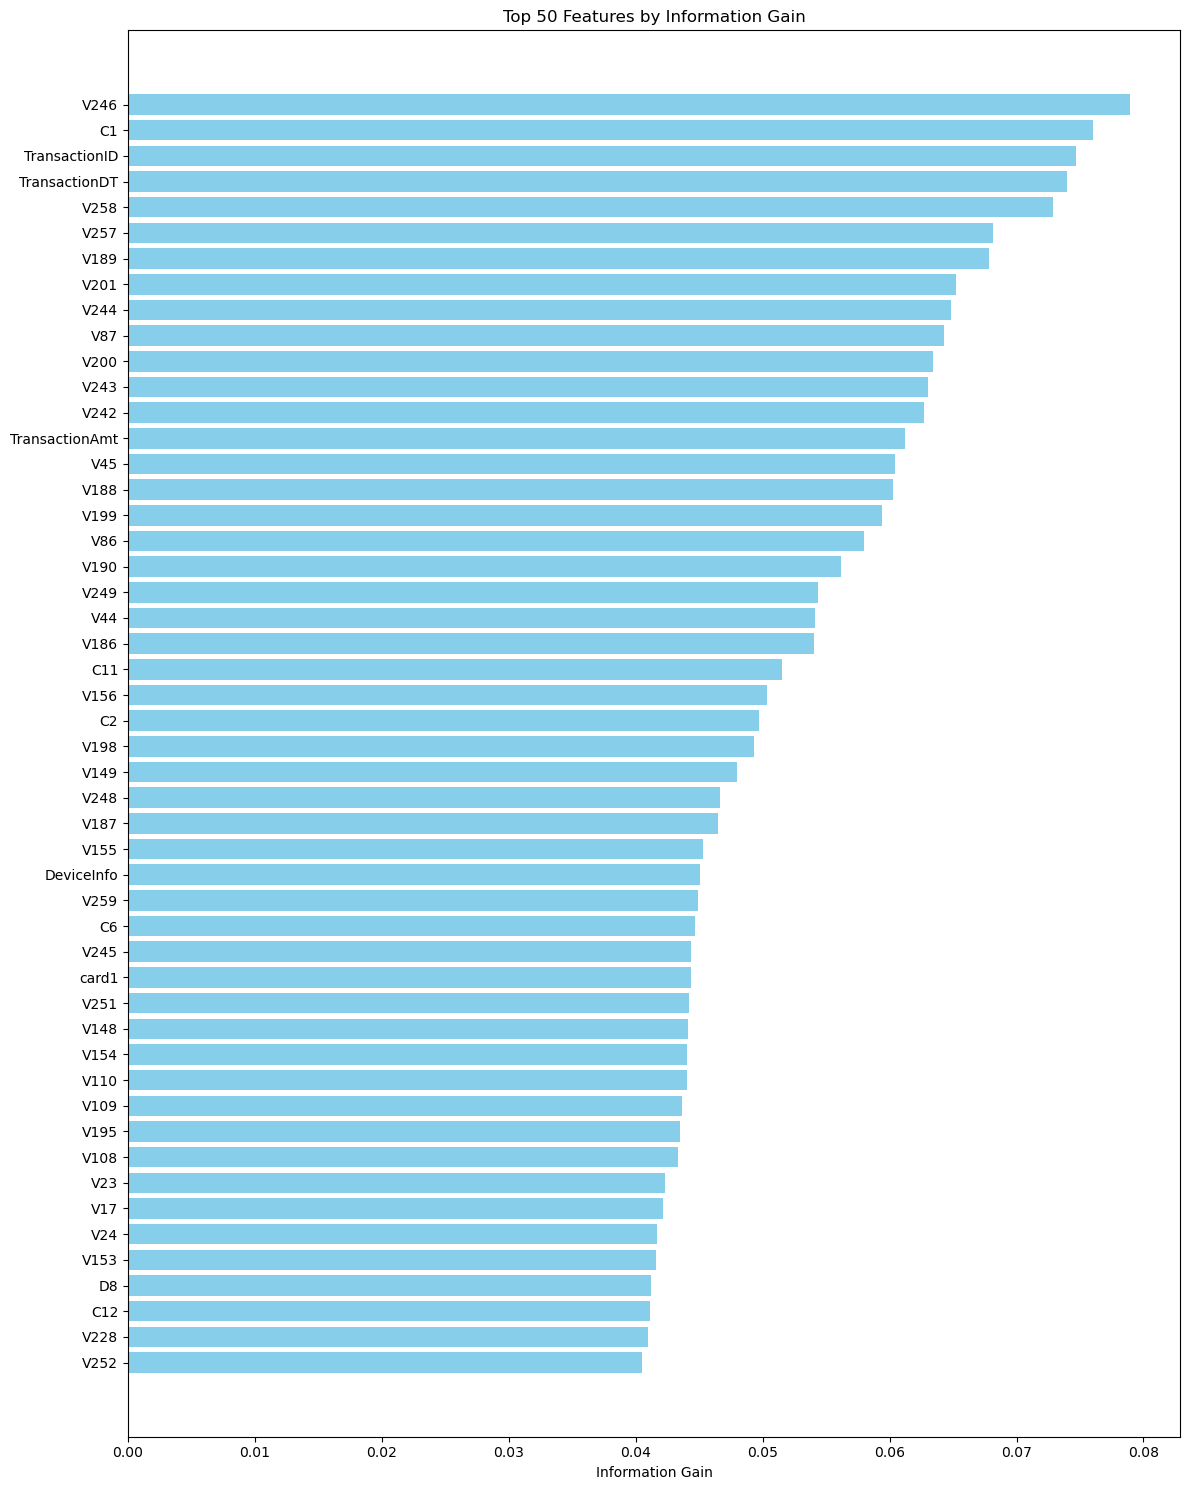

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Loading CSV data
ig = pd.read_csv('information_gain.csv') 

# Sorting by Information_Gain (descending)
ig_sorted = ig.sort_values(by='Information_Gain', ascending=False)

# Optionally limit to top N features
top_n = 50
ig_top = ig_sorted.head(top_n)

# Ploting horizontal bar chart
plt.figure(figsize=(12, 15))
plt.barh(ig_top['Feature'], ig_top['Information_Gain'], color='skyblue')
plt.xlabel('Information Gain')
plt.title(f'Top {top_n} Features by Information Gain')
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()

**FISHER'S SCORE**

In [55]:
df = pd.read_csv("/Users/roshanshetty/Downloads/PROJECT_PHASE_1/Notebook/cleaned_fraud_dataset.csv")

# Check binary target 
label_column = 'isFraud'
if label_column not in df.columns:
    raise ValueError("Target column 'isFraud' not found in the DataFrame.")

y = df[label_column]
if len(np.unique(y)) != 2:
    raise ValueError("Fisher Score works only for binary classification.")

# Selecting the numerical features 
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != label_column]

# Calculate Fisher Scores
scores = {}
c1, c2 = np.unique(y)

for col in numerical_cols:
    f = df[col].values
    mu = np.mean(f)
    mu1 = np.mean(f[y == c1])
    mu2 = np.mean(f[y == c2])
    sigma1 = np.var(f[y == c1])
    sigma2 = np.var(f[y == c2])
    numerator = (mu1 - mu)**2 + (mu2 - mu)**2
    denominator = sigma1 + sigma2
    score = numerator / denominator if denominator != 0 else 0
    scores[col] = score

# Ranking features by Fisher Score 
sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)

# Display top features 
print("\n=== Top Features Ranked by Fisher Score ===")
for feature, score in sorted_scores[:15]:
    print(f"{feature}: {score:.4f}")

# Optional: Save to CSV 
fisher_df = pd.DataFrame(sorted_scores, columns=["Feature", "FisherScore"])
fisher_df.to_csv("fisher_score_ranked_features.csv", index=False)
print("\n Fisher scores saved to 'fisher_score_ranked_features.csv'")


=== Top Features Ranked by Fisher Score ===
V258: 0.1671
V242: 0.1661
V244: 0.1659
V257: 0.1653
V246: 0.1519
card3: 0.1390
V243: 0.1340
id_17: 0.1332
id_35: 0.1331
V189: 0.1314
V201: 0.1286
V230: 0.1198
V188: 0.1182
V200: 0.1160
V199: 0.1098

 Fisher scores saved to 'fisher_score_ranked_features.csv'


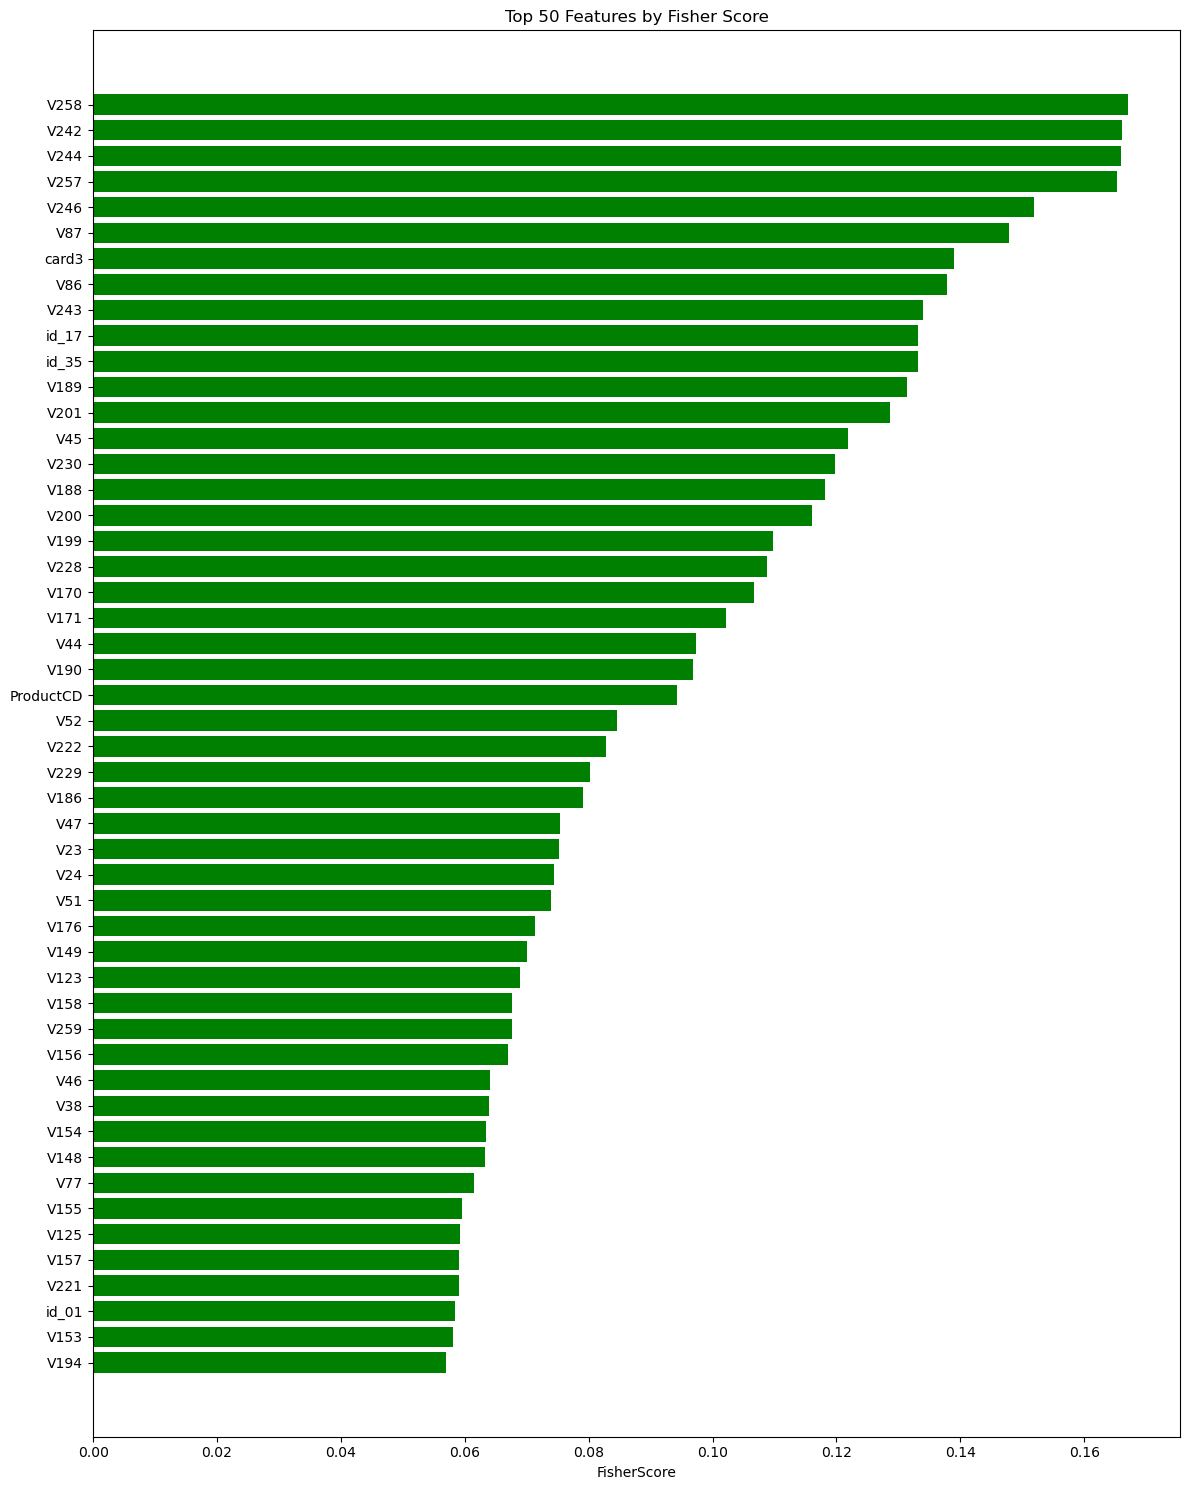

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Loading CSV data
fs = pd.read_csv('fisher_score_ranked_features.csv') 

# Sorting by Fisher's Score(descending)
fs_sorted = fs.sort_values(by='FisherScore', ascending=False)

# Optionally limit to top N features
top_n = 50
fs_top = fs_sorted.head(top_n)

# Ploting horizontal bar chart
plt.figure(figsize=(12, 15))
plt.barh(fs_top['Feature'], fs_top['FisherScore'], color='green')
plt.xlabel('FisherScore')
plt.title(f'Top {top_n} Features by Fisher Score')
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()

**CORRELATION COEFFICIENT**

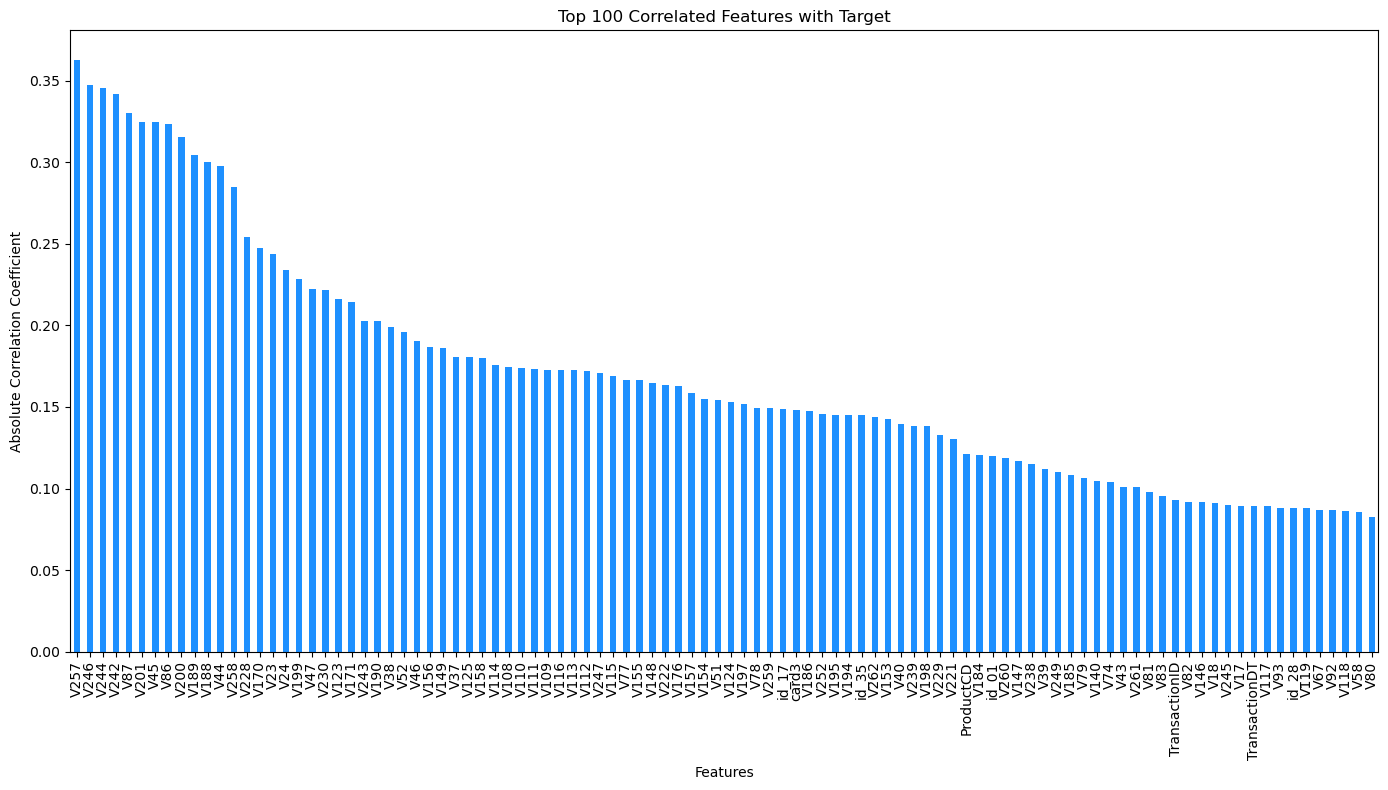

In [59]:
# Load  dataset
df = pd.read_csv("/Users/roshanshetty/Downloads/PROJECT_PHASE_1/Notebook/cleaned_fraud_dataset.csv")

# Identifying the target variable 
target_col = "isFraud" 
target = df[target_col]

# Selecting the  numeric features excluding the target column
numeric_features = df.select_dtypes(include='number').drop(columns=[target_col])

# Calculating absolute Pearson correlation with the target
correlation_scores = numeric_features.corrwith(target).abs()

# Get top 50 features with highest correlation
top_50_corr = correlation_scores.sort_values(ascending=False).head(100)

# Plot
plt.figure(figsize=(14, 8))
top_50_corr.plot(kind='bar', color='dodgerblue')
plt.title('Top 100 Correlated Features with Target')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation Coefficient')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [60]:
print("=== Top 50 Features Correlated with Target ===")
top_50_corr = correlation_scores.sort_values(ascending=False).head(100)
for i, (feature, score) in enumerate(top_50_corr.items(), start=1):
    print(f"{i:2d}. {feature:30s} | Correlation: {score:.4f}")

=== Top 50 Features Correlated with Target ===
 1. V257                           | Correlation: 0.3628
 2. V246                           | Correlation: 0.3477
 3. V244                           | Correlation: 0.3454
 4. V242                           | Correlation: 0.3420
 5. V87                            | Correlation: 0.3302
 6. V201                           | Correlation: 0.3245
 7. V45                            | Correlation: 0.3245
 8. V86                            | Correlation: 0.3234
 9. V200                           | Correlation: 0.3154
10. V189                           | Correlation: 0.3048
11. V188                           | Correlation: 0.3002
12. V44                            | Correlation: 0.2979
13. V258                           | Correlation: 0.2851
14. V228                           | Correlation: 0.2542
15. V170                           | Correlation: 0.2474
16. V23                            | Correlation: 0.2440
17. V24                            | Corr

In [61]:
# Save top 50 features to CSV
top_50_corr.to_csv('corr.csv', index=False)
print("Saved top 100 features to 'corr.csv'")

Saved top 100 features to 'corr.csv'


**DISPERSION RATIO**

In [62]:
numerical_cols = df.select_dtypes(include=[np.number]).columns
numerical_cols = [col for col in numerical_cols if col != 'isFraud']

dispersion_scores = {}

for col in numerical_cols:
    f = df[col].values
    sigma_total = np.var(f)
    sigma1 = np.var(df[df['isFraud'] == 0][col])
    sigma2 = np.var(df[df['isFraud'] == 1][col])
    sigma_avg = (sigma1 + sigma2) / 2

    # Avoid division by zero
    score = sigma_total / sigma_avg if sigma_avg != 0 else 0
    dispersion_scores[col] = score

# Rank features
sorted_dispersion = sorted(dispersion_scores.items(), key=lambda x: x[1], reverse=True)

print("Top features by Dispersion Ratio:")
for feat, score in sorted_dispersion[:15]:
    print(f"{feat}: {score:.4f}")

Top features by Dispersion Ratio:
V133: 1.8439
V134: 1.8438
V127: 1.8436
V322: 1.8434
V132: 1.8434
V324: 1.8433
V128: 1.8433
V323: 1.8430
V126: 1.8429
V316: 1.8429
V331: 1.8428
V143: 1.8428
V332: 1.8428
V333: 1.8425
V293: 1.8425


In [63]:
dispersion_df = pd.DataFrame(sorted_dispersion, columns=["Feature", "DispersionRatio"])

# Save to CSV 
output_file = "dispersion_ratio_features.csv"
dispersion_df.to_csv(output_file, index=False)

# Output preview
print(f"Saved dispersion scores to '{output_file}'")
print("\n=== Top 50 Features by Dispersion Ratio ===")
print(dispersion_df.head(50).to_string(index=False))

Saved dispersion scores to 'dispersion_ratio_features.csv'

=== Top 50 Features by Dispersion Ratio ===
Feature  DispersionRatio
   V133         1.843902
   V134         1.843765
   V127         1.843574
   V322         1.843423
   V132         1.843389
   V324         1.843335
   V128         1.843312
   V323         1.843027
   V126         1.842913
   V316         1.842905
   V331         1.842784
   V143         1.842772
   V332         1.842760
   V333         1.842547
   V293         1.842471
   V306         1.842332
   V279         1.842253
   V164         1.842232
   V211         1.838477
   V311         1.833532
   V202         1.832033
   V136         1.831033
   V329         1.830519
   V177         1.829635
   V308         1.828514
   V167         1.828003
   V179         1.827421
   V318         1.827078
   V178         1.826641
   V269         1.825177
   V165         1.822915
   V137         1.822750
   V213         1.822131
   V321         1.820586
   V168         1.819

**SELECTED FEATURES**

In [77]:
selected_columns = [
    # Core Transaction Features  
    'DeviceType', 'card6', 'P_emaildomain', 'R_emaildomain','TransactionAmt', 'TransactionDT', 'TransactionID', 'ProductCD',  
    'Amt_to_mean_ratio', 'Amt_to_user_mean_ratio',  

    # High-Value Cards & IDs  
    'card1', 'card2', 'card3', 'id_01', 'id_17',  

    # Top C/D Features  
    'C1', 'C2', 'C10', 'C11', 'C12', 'C13', 'C14',  
    'D2', 'D3', 'D6', 'D8', 'D13', 'D15',  

    # Top V Features (Correlation + Dispersion)  
    'V15', 'V18', 'V23', 'V24', 'V45', 'V52', 'V58', 'V67',  
    'V87', 'V130', 'V133', 'V156', 'V149', 'V155', 'V148',  
    'V228', 'V242', 'V243', 'V244', 'V246', 'V257', 'V258',  

    # Target  
    'isFraud'  
]

# Filtering the dataset to keep only these columns
filtered_features = df[selected_columns]

# Save the filtered data to a new CSV file
filtered_features.to_csv('filtered_features.csv', index=False)

print("Filtered columns saved to 'filtered_features.csv'")

Filtered columns saved to 'filtered_features.csv'


In [78]:
df.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,V332,V333,V334,V335,V336,V337,V338,V339,Amt_to_mean_ratio,Amt_to_user_mean_ratio
0,2987004,0.0,70787.0,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.591334,0.598802
1,2987008,-5.0,98945.0,0.0,0.0,0.0,-5.0,14.0,-34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.177400,0.177957
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,14.0,-34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.897492,1.267974
3,2987011,-5.0,221832.0,0.0,0.0,0.0,-6.0,14.0,-34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.195081,0.407207
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,14.0,-34.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.354801,0.676692




<ul style="text-align:left; font-size:20px;">
  <li><b>Balancing Techniques</b></li>
</ul>

In [79]:
df= pd.read_csv('filtered_features.csv')

In [80]:
# Fill any new NaNs just in case
df.fillna(0, inplace=True)

# Prepare features (excluding isFraud and TransactionID)
feature_cols = df.drop(['isFraud', 'TransactionID'], axis=1, errors='ignore').columns
X = df[feature_cols]
y = df['isFraud']

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [85]:
X.head()

,DeviceType,card6,P_emaildomain,R_emaildomain,TransactionAmt,TransactionDT,ProductCD,Amt_to_mean_ratio,Amt_to_user_mean_ratio,card1,...,V149,V155,V148,V228,V242,V243,V244,V246,V257,V258
0,1,1,16,16,50.000,86506,1,0.591334,0.598802,4497,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1,2,1,16,15.000,86535,1,0.177400,0.177957,2803,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0,1,16,16,75.887,86549,0,0.897492,1.267974,16496,...,1.0,1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0,2,19,19,16.495,86555,0,0.195081,0.407207,4461,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0,2,2,16,30.000,86620,1,0.354801,0.676692,1790,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


 **Dimensionality Reduction (PCA)**

In [81]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio by PCA components:", pca.explained_variance_ratio_)

Explained variance ratio by PCA components: [0.1427645  0.13603802 0.08456509 0.07138637 0.05099673 0.04569702
 0.03872188 0.03449441 0.0309528  0.0292447 ]


In [87]:
X_pca

array([[-1.58758426,  1.05262755, -2.42405071, ..., -0.24936475,
        -0.32253056,  0.45061002],
       [-1.46586583,  0.97171106, -2.14904722, ..., -0.53253064,
        -0.93864297,  0.52008485],
       [ 0.1252885 , -0.54046188,  0.17516513, ..., -0.28268679,
         2.75851556, -2.31703216],
       ...,
       [ 0.08776987, -0.35274119,  1.55921814, ...,  1.33367145,
        -0.80181943, -0.3778489 ],
       [-0.85487809,  0.21685256, -0.24656408, ...,  1.57307544,
        -0.28511976, -0.86778247],
       [ 0.24512785, -0.43937776,  1.83751643, ...,  1.81231957,
        -1.03151349,  0.07173721]])

In [89]:
# Save PCA-transformed data
pca_df = pd.DataFrame(X_pca, columns=[f'PCA_{i+1}' for i in range(X_pca.shape[1])])
pca_df['isFraud'] = y.values
pca_df.to_csv("pca_transformed_dataset.csv", index=False)
print("PCA data saved to 'pca_transformed_dataset.csv'")

# Save PCA object for future transforms
with open('pca_model.pkl', 'wb') as f:
    pickle.dump(pca, f)
print("PCA model object saved as 'pca_model.pkl'")

PCA data saved to 'pca_transformed_dataset.csv'
PCA model object saved as 'pca_model.pkl'


**Imbalanced Data Handling**

In [83]:
# --- SMOTE (oversampling) ---
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_pca, y)
print("SMOTE oversampled shape:", X_smote.shape, y_smote.value_counts())

# --- Undersampling ---
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_pca, y)
print("Undersampled shape:", X_under.shape, y_under.value_counts())


SMOTE oversampled shape: (265830, 10) isFraud
0    132915
1    132915
Name: count, dtype: int64
Undersampled shape: (22636, 10) isFraud
0    11318
1    11318
Name: count, dtype: int64


**Train/Test Split and Class Weight**

In [84]:
# Using SMOTE data
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# Logistic Regression with class_weight
lr = LogisticRegression(class_weight='balanced', max_iter=500)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("\nLogistic Regression (class_weight='balanced') Evaluation on SMOTE data:")
print(classification_report(y_test, y_pred))


Logistic Regression (class_weight='balanced') Evaluation on SMOTE data:
              precision    recall  f1-score   support

           0       0.70      0.87      0.78     26382
           1       0.84      0.63      0.72     26784

    accuracy                           0.75     53166
   macro avg       0.77      0.75      0.75     53166
weighted avg       0.77      0.75      0.75     53166



<p style="text-align:center;">
  <span style="font-size:30px;"><b>3. Bagging Techniques and Baseline Comparisons</b></span>
</p>

<b>Objective:</b> Train and evaluate baseline and bagging models.

In [90]:
# === Load your final selected dataset ===
df = pd.read_csv("filtered_features.csv")

# === Prepare features and target ===
X = df.drop(columns=['isFraud'])
y = df['isFraud']

# === Scale features (important for LR & KNN) ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)



<ul style="text-align:left; font-size:20px;">
  <li><b>Baseline Models</b></li>
</ul>

In [94]:
# === Define models ===
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=500),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Bagging': BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
}


In [95]:
# === Store results ===
results = []

# === Train and evaluate ===
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else np.zeros_like(y_pred)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'ROC-AUC': roc
    })

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=4))



=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9731    0.8703    0.9188     26583
           1     0.3203    0.7178    0.4429      2264

    accuracy                         0.8583     28847
   macro avg     0.6467    0.7940    0.6809     28847
weighted avg     0.9219    0.8583    0.8815     28847


=== Decision Tree ===
              precision    recall  f1-score   support

           0     0.9772    0.9743    0.9757     26583
           1     0.7081    0.7328    0.7202      2264

    accuracy                         0.9553     28847
   macro avg     0.8426    0.8535    0.8480     28847
weighted avg     0.9561    0.9553    0.9557     28847


=== KNN ===
              precision    recall  f1-score   support

           0     0.9628    0.9888    0.9756     26583
           1     0.8072    0.5512    0.6551      2264

    accuracy                         0.9544     28847
   macro avg     0.8850    0.7700    0.8154     28847
weighted 



<ul style="text-align:left; font-size:20px;">
  <li><b>Model Analysis</b></li>
</ul>

In [96]:
# === Create results DataFrame ===
results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False)
print("\n=== Summary Table ===")
print(results_df.to_string(index=False))

# === Save results ===
results_df.to_csv("baseline_bagging_evaluation_report.csv", index=False)
print("\n✅ Evaluation report saved to 'baseline_bagging_evaluation_report.csv'")


=== Summary Table ===
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
      Random Forest  0.973619   0.938704 0.710247  0.808650 0.966076
            Bagging  0.972683   0.917421 0.716431  0.804563 0.955914
      Decision Tree  0.955316   0.708067 0.732774  0.720208 0.853522
                KNN  0.954449   0.807245 0.551237  0.655118 0.886021
Logistic Regression  0.858287   0.320260 0.717756  0.442900 0.874643

✅ Evaluation report saved to 'baseline_bagging_evaluation_report.csv'


In [101]:
for name, model in models.items():
    model.fit(X_train, y_train)
    mem_usage_kb = asizeof.asizeof(model) / 1024
    print(f"{name}: Approx. model memory usage = {mem_usage_kb:.2f} KB")

Logistic Regression: Approx. model memory usage = 3.28 KB
Decision Tree: Approx. model memory usage = 1.82 KB
KNN: Approx. model memory usage = 46877.98 KB
Random Forest: Approx. model memory usage = 60.71 KB
Bagging: Approx. model memory usage = 66.30 KB


<p style="text-align:center;">
  <span style="font-size:30px;"><b>4.Boosting Algorithms</b></span>
</p>

<b>Objective:</b>Explore and optimize boosting techniques.

In [113]:
# === Load your final selected dataset ===
df = pd.read_csv("filtered_features.csv")

X = df.drop(columns=['isFraud'])
y = df['isFraud']

# === Train-test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)




<ul style="text-align:left; font-size:20px;">
  <li><b>Boosting Techniques</b></li>
</ul>

In [106]:
# === Define boosting models ===
models = {
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, eval_metric='logloss', use_label_encoder=False),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3),
    'CatBoost': cb.CatBoostClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, verbose=0)
}



<ul style="text-align:left; font-size:20px;">
  <li><b>Hyperparameter Tuning</b></li>
</ul>

In [108]:
param_dist = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

xgb_model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("✅ Best Parameters:", random_search.best_params_)
print("✅ Best F1-Score from CV:", random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.8; total time=   2.8s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.6; total time=   3.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.6; total time=   3.1s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=9, n_estimators=100, subsample=0.8; total time=   3.0s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.7; total time=   5.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.7; total time=   5.2s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.9; total time=   2.9s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.9; total time=   2.9s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=9, n_estimators=100, subsample=0.9; total time=   3.2s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   3.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   3.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.7; total time=   5.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.7; total time=   2.5s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   3.3s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.7; total time=   2.9s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.7; total time=   3.0s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=   2.6s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=9, n_estimators=300, subsample=1.0; total time=   5.6s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=9, n_estimators=300, subsample=1.0; total time=   5.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=0.6; total time=   4.3s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=9, n_estimators=300, subsample=1.0; total time=   5.6s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=0.6; total time=   4.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=9, n_estimators=200, subsample=0.6; total time=   4.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.4s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   1.5s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.8; total time=   2.8s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.7; total time=   3.6s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.7; total time=   3.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.7; total time=   3.9s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7; total time=   2.7s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7; total time=   2.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.9; total time=   4.1s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.9; total time=   4.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.9; total time=   4.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7; total time=   2.7s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.1s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.9; total time=   2.3s
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.9; total time=   2.3s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:30:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.1s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7; total time=   4.3s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7; total time=   4.5s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=9, n_estimators=200, subsample=0.7; total time=   4.5s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:31:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:31:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:31:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:31:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=9, n_estimators=100, subsample=0.9; total time=   2.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.6; total time=   5.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.2s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.8; total time=   1.2s


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:31:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:31:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:31:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:31:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.6; total time=   5.3s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=9, n_estimators=200, subsample=0.6; total time=   5.5s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.8; total time=   1.7s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=   3.0s
[CV] END colsample_bytree=0.8, learning_rate=0.05, max_depth=5, n_estimators=300, subsample=0.8; total time=   2.6s
✅ Best Parameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 



<ul style="text-align:left; font-size:20px;">
  <li><b>Boosting Comparisons</b></li>
</ul>

In [118]:
# === Models dictionary ===
models = {
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3),
    'CatBoost': cb.CatBoostClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, verbose=0),
    'Bagging': BaggingClassifier(estimator=GradientBoostingClassifier(), n_estimators=10, random_state=42)
}

results = []

for name, model in models.items():
    print(f"\n=== {name} ===")
    start_time = time.time()

    if name in ["XGBoost", "LightGBM", "CatBoost"]:
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    else:
        model.fit(X_train, y_train)

    train_time = time.time() - start_time

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'Train Time (s)': train_time,
        'Memory (KB)': asizeof.asizeof(model) / 1024
    }
    results.append(metrics)

    print(classification_report(y_test, y_pred, digits=4))
    print(f"Training time: {train_time:.2f}s | Memory: {metrics['Memory (KB)']:.2f} KB")

# === Results summary ===
results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False)
print("\n=== Models Summary ===")
print(results_df.to_string(index=False))

results_df.to_csv("boosting_bagging_models_evaluation_report.csv", index=False)
print("\n Saved to 'boosting_bagging_models_evaluation_report.csv'")


=== Gradient Boosting ===
              precision    recall  f1-score   support

           0     0.9642    0.9926    0.9782     26583
           1     0.8671    0.5676    0.6861      2264

    accuracy                         0.9592     28847
   macro avg     0.9156    0.7801    0.8321     28847
weighted avg     0.9566    0.9592    0.9553     28847

Training time: 27.01s | Memory: 8.63 KB

=== XGBoost ===
[0]	validation_0-logloss:0.24194
[1]	validation_0-logloss:0.22526
[2]	validation_0-logloss:0.21434
[3]	validation_0-logloss:0.20558
[4]	validation_0-logloss:0.19846
[5]	validation_0-logloss:0.19279
[6]	validation_0-logloss:0.18826
[7]	validation_0-logloss:0.18419
[8]	validation_0-logloss:0.18107
[9]	validation_0-logloss:0.17744
[10]	validation_0-logloss:0.17467
[11]	validation_0-logloss:0.17195
[12]	validation_0-logloss:0.16968
[13]	validation_0-logloss:0.16783
[14]	validation_0-logloss:0.16582
[15]	validation_0-logloss:0.16413
[16]	validation_0-logloss:0.16251
[17]	validation_0-log

<p style="text-align:center;">
  <span style="font-size:30px;"><b>5.Hybrid Models and Unsupervised Technique</b></span>
</p>

<b>Objective:</b>: Implement hybrid and anomaly detection models



<ul style="text-align:left; font-size:20px;">
  <li><b>Hybrid Models</b></li>
</ul>

In [119]:
# === Base classifiers for stacking ===
estimators = [
    ('lr', LogisticRegression(max_iter=500)),
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
]

stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

# === Train stacking ===
stack_model.fit(X_train, y_train)
y_pred_stack = stack_model.predict(X_test)
y_proba_stack = stack_model.predict_proba(X_test)[:, 1]

print("\n=== Stacking Hybrid Model ===")
print(classification_report(y_test, y_pred_stack, digits=4))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_stack):.4f}")



=== Stacking Hybrid Model ===
              precision    recall  f1-score   support

           0     0.9789    0.9936    0.9862     26583
           1     0.9088    0.7482    0.8207      2264

    accuracy                         0.9743     28847
   macro avg     0.9438    0.8709    0.9035     28847
weighted avg     0.9734    0.9743    0.9732     28847

ROC-AUC: 0.9701




<ul style="text-align:left; font-size:20px;">
  <li><b>Anomaly Detection</b></li>
</ul>

In [120]:
# === Anomaly detection: Isolation Forest ===
iso_model = IsolationForest(contamination=0.05, random_state=42)
iso_model.fit(X_train)
y_pred_iso = iso_model.predict(X_test)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

print("\n=== Isolation Forest ===")
print(classification_report(y_test, y_pred_iso, digits=4))

# === Anomaly detection: One-Class SVM ===
svm_model = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')
svm_model.fit(X_train)
y_pred_svm = svm_model.predict(X_test)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

print("\n=== One-Class SVM ===")
print(classification_report(y_test, y_pred_svm, digits=4))


=== Isolation Forest ===
              precision    recall  f1-score   support

           0     0.9358    0.9656    0.9505     26583
           1     0.3552    0.2226    0.2737      2264

    accuracy                         0.9073     28847
   macro avg     0.6455    0.5941    0.6121     28847
weighted avg     0.8903    0.9073    0.8974     28847


=== One-Class SVM ===
              precision    recall  f1-score   support

           0     0.9223    0.9490    0.9355     26583
           1     0.0930    0.0614    0.0740      2264

    accuracy                         0.8794     28847
   macro avg     0.5077    0.5052    0.5047     28847
weighted avg     0.8572    0.8794    0.8679     28847





<ul style="text-align:left; font-size:20px;">
  <li><b>Clustering for Fraud Patterns</b></li>
</ul>

In [123]:
# === Clustering: K-Means ===
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_test)

print("\n=== K-Means Clustering ===")
print(pd.Series(kmeans_labels).value_counts())

# === Clustering: DBSCAN ===
dbscan = DBSCAN(eps=3, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_test)

print("\n=== DBSCAN Clustering ===")
print(pd.Series(dbscan_labels).value_counts())


=== K-Means Clustering ===
1    17218
0    11629
Name: count, dtype: int64

=== DBSCAN Clustering ===
-1    28847
Name: count, dtype: int64




<ul style="text-align:left; font-size:20px;">
  <li><b>Model Fusion</b></li>
</ul>

In [124]:
# === Model Fusion: Weighted average ===
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(X_train, y_train)

stack_preds = stack_model.predict_proba(X_test)[:, 1]
rf_preds = rf_model.predict_proba(X_test)[:, 1]
lr_preds = lr_model.predict_proba(X_test)[:, 1]

final_proba = 0.6 * stack_preds + 0.3 * rf_preds + 0.1 * lr_preds
final_pred = (final_proba >= 0.5).astype(int)

print("\n=== Model Fusion (Weighted Average) ===")
print(classification_report(y_test, final_pred, digits=4))
print(f"ROC-AUC: {roc_auc_score(y_test, final_proba):.4f}")


=== Model Fusion (Weighted Average) ===
              precision    recall  f1-score   support

           0     0.9777    0.9949    0.9862     26583
           1     0.9243    0.7337    0.8180      2264

    accuracy                         0.9744     28847
   macro avg     0.9510    0.8643    0.9021     28847
weighted avg     0.9735    0.9744    0.9730     28847

ROC-AUC: 0.9676


<p style="text-align:center;">
  <span style="font-size:30px;"><b>6.Final Evaluation and Pipeline Development</b></span>
</p>

<b>Objective:</b>: Develop the fraud detection pipeline and summarize findings



<ul style="text-align:left; font-size:20px;">
  <li><b>Pipeline Development</b></li>
</ul>

In [126]:
# === Load cleaned and feature-selected data ===
df = pd.read_csv("filtered_features.csv")

X = df.drop(columns=['isFraud'])
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# === Define final pipeline ===
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),            # Preprocessing
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))  # Model
])

# === Train pipeline ===
start_time = time.time()
final_pipeline.fit(X_train, y_train)
train_time = time.time() - start_time

# === Predictions ===
y_pred = final_pipeline.predict(X_test)
y_proba = final_pipeline.predict_proba(X_test)[:, 1]

# === Metrics ===
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

# === Display results ===
print("\n=== Final Pipeline Evaluation ===")
print(classification_report(y_test, y_pred, digits=4))
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")
print(f"Training time: {train_time:.2f} seconds")

# === Save final model ===
import joblib
joblib.dump(final_pipeline, "final_fraud_detection_pipeline.pkl")
print("\n Final pipeline saved as 'final_fraud_detection_pipeline.pkl'")


=== Final Pipeline Evaluation ===
              precision    recall  f1-score   support

           0     0.9754    0.9961    0.9856     26583
           1     0.9388    0.7045    0.8049      2264

    accuracy                         0.9732     28847
   macro avg     0.9571    0.8503    0.8953     28847
weighted avg     0.9725    0.9732    0.9714     28847

Accuracy : 0.9732
Precision: 0.9388
Recall   : 0.7045
F1-Score : 0.8049
ROC-AUC  : 0.9648
Training time: 18.81 seconds

 Final pipeline saved as 'final_fraud_detection_pipeline.pkl'




<ul style="text-align:left; font-size:20px;">
  <li><b>Performance Comparison</b></li>
</ul>

In [127]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Logistic Regression': LogisticRegression(max_iter=500, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = []

for name, clf in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', clf)
    ])
    start_time = time.time()
    pipe.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'Train Time (s)': train_time
    })

results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False)
print("\n=== Final Models Comparison ===")
print(results_df.to_string(index=False))
results_df.to_csv("final_models_comparison.csv", index=False)
print("\n Saved comparison to 'final_models_comparison.csv'")


=== Final Models Comparison ===
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Train Time (s)
      Random Forest  0.973723   0.939323 0.711131  0.809452 0.964123       18.654658
            XGBoost  0.971124   0.907692 0.703622  0.792735 0.970950        0.577305
Logistic Regression  0.858113   0.319874 0.717314  0.442447 0.874814        2.572813

 Saved comparison to 'final_models_comparison.csv'
